In [ ]:
!pip -q install matplotlib_venn_wordcloud
!pip -q install lime
!pip install -q transformers
!pip install -q sentence-transformers

from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/Tesi\ Magistrale\ 204963/Progetto/
 
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 275 kB 4.3 MB/s 
     |████████████████████████████████| 2.6 MB 4.1 MB/s 
     |████████████████████████████████| 636 kB 46.0 MB/s 
     |████████████████████████████████| 3.3 MB 38.6 MB/s 
     |████████████████████████████████| 895 kB 39.2 MB/s 
     |████████████████████████████████| 85 kB 2.3 MB/s 
     |████████████████████████████████| 1.2 MB 27.2 MB/s 
Mounted at /content/drive
/content/drive/MyDrive/Tesi Magistrale 204963/Progetto


In [ ]:
from math import ceil

import torch
import numpy as np
import os
import pickle
import nltk
import pandas as pd
import tensorflow as tsf
import matplotlib.pyplot as plt
from matplotlib_venn_wordcloud import venn2_wordcloud

from autoencoders.model import VAE, DAE, AAE, reparameterize
from autoencoders.vocab import Vocab
from autoencoders.noise import noisy
from autoencoders.utils import set_seed, strip_eos
from autoencoders.batchify import get_batches
from classifier.classifier_nn import build_nn
from nltk.corpus import stopwords
import lime.lime_text
from text_interpretable import *
from coherence import compute_explanations, compare_explanations, compute_score

from sentence_transformers import SentenceTransformer, util
SentenceTransformer('stsb-roberta-large')

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def encode(sents):
    sents_conv = pd.Series(sents).apply(lambda x: x.split())
    batches, order = get_batches(sents_conv, vocab, 256, device)
    z = []
    for inputs, _ in batches:
        mu, logvar = model.encode(inputs)
        zi = reparameterize(mu, logvar)
        z.append(zi.detach().cpu().numpy())
    z = np.concatenate(z, axis=0)
    z_ = np.zeros_like(z)
    z_[np.array(order)] = z
    return z_


def decode(z, batch_size=512):
    sents = []
    for i in range(ceil(len(z)/batch_size)):
        zi = torch.tensor(z[i*batch_size: min((i+1)*batch_size, len(z))], device=device)
        outputs = model.generate(zi, 35, 'greedy').t()
        results = pd.Series(outputs[:, 1:].cpu()).apply(lambda x: [vocab.idx2word[id] for id in x])
        sents = np.append(sents, results, axis=0)
    return pd.Series(strip_eos(sents)).apply(lambda x: ' '.join(x)).tolist()


def get_model(path):
    ckpt = torch.load(path)
    train_args = ckpt['args']
    model = {'dae': DAE, 'vae': VAE, 'aae': AAE}[train_args.model_type](
        vocab, train_args).to(device)
    model.load_state_dict(ckpt['model'])
    model.flatten()
    model.eval()
    return model

def print_lime_latent_explanation(i, set1, set2, sents, lt):
    f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, facecolor='#ffddb7', figsize=(6.4, 4))
    f.set_rasterized(True)
    ax1.axis(False)
    ax1.text(0.3, 1, 'Classification: ' + str(np.where(classifier_fn([sents[i]])[0, 0] == 0, 'Negative', 'Positive')),
             horizontalalignment='center', color='#355c7d', fontsize=14)
    ax1.text(0.5, 0.5, 'SENTENCE: \n' + sents[i] + '\n LEMMATIZATION: \n[' + lt([sents[i]])[0] + ']', wrap=True,
             horizontalalignment='center', verticalalignment='center')
    venn2_wordcloud([set1[i], set2[i]], set_labels=["LIME", "XXX"],
                    set_edgecolors=['#584848', '#f3b54a'], ax=ax0)
    plt.savefig('images\explanation_{}.eps'.format(i), facecolor='#ffddb7')
    plt.show()

def load_sent(path):
    sents = []
    with open(path) as f:
        for line in f:
            sents.append(line)
    return sents

def general_delete_rep(gow):
  '''Return list of unique words deleting repeated ones from group of words.'''
  ulist = []
  [ulist.append(x) for x in gow if x not in ulist]
  return ulist

In [ ]:
data = 'yelp'
num_example_per_classes = 500 # SOLO TEST
if data == 'yelp':
  path = 'checkpoints/yelp/daae'
  dataset = 'data/yelp/sentiment'
  class_folder = 'classifier/yelp'

  # Exctract data of interest
  # data_classes = data[(data['stars'] == 1) | (data['stars'] == 5)]
  # x = data_classes['text']
  # y = data_classes['stars'].where(data_classes['stars'] == 1, other=2) - 1
  sents = load_sent(os.path.join(dataset, '1000.pos'))
  sents = sents[:num_example_per_classes] # SOLO TEST
  n_pos = len(sents)
  sents.extend(load_sent(os.path.join(dataset, '1000.neg')))
  sents = sents[:2*num_example_per_classes] # SOLO TEST
  y = np.ones(len(sents), dtype=int)
  y[n_pos:] = 0

  vocab = Vocab(os.path.join(path, 'vocab.txt'))
  # set_seed(1111)
  cuda = torch.cuda.is_available()
  device = torch.device("cuda" if cuda else "cpu")
  model = get_model(os.path.join(path, 'model.pt'))

  vec = pickle.load(open(os.path.join(class_folder, 'vec_nn.pickle'), 'rb'))
  classifier = build_nn(len(vec.vocabulary_))
  classifier.load_weights(os.path.join(class_folder, 'model_dense.hdf5'))
  
  def classifier_fn(s):
    p = classifier.predict(vec.transform(s).toarray())
    return np.append(1-p, p, axis=1)

  cv_d = pickle.load(open('mytest/yelp/new_CV.pickle','rb'))
  score_fabrizio_correzione = pickle.load(open('mytest/yelp/GOW_score.pickle','rb'))

if data == 'yahoo':
  path = 'checkpoints/yahoo/daae' # cambio con riga dopo per mettere la mia rete
  #path = 'mytest/checkpoint/yahoo/daae_1/'
  class_folder = 'classifier/yahoo'
  dataset = 'data/yahoo_answers_csv/'
  sents = pickle.load(open(os.path.join(dataset, 'test_2_processed.pickle'), 'rb'))
  y = pickle.load(open(os.path.join(dataset, 'test_2_processed_y.pickle'), 'rb'))

  df = pd.DataFrame( np.asarray([sents, y]).T, columns=['Sentence', 'Polarity'] )
  frames = [ df[df['Polarity']=='1'].sample(num_example_per_classes), df[df['Polarity']=='0'].sample(num_example_per_classes)]
  df = pd.concat( frames )
  sents = list(df['Sentence'])
  y = np.asarray( [int(s) for s in df['Polarity']] )

  vocab = Vocab(os.path.join(path, 'vocab.txt'))
  # set_seed(1111)
  cuda = torch.cuda.is_available()
  device = torch.device("cuda" if cuda else "cpu")
  model = get_model(os.path.join(path, 'model.pt'))

  mnb = pickle.load(open(os.path.join(class_folder, 'mnb.pickle'), 'rb'))
  vec = pickle.load(open(os.path.join(class_folder, 'vec.pickle'), 'rb'))
  classifier_fn = lambda s: mnb.predict_proba(vec.transform(s))

  cv_d = pickle.load(open('mytest/yahoo/new_CV.pickle','rb'))
  score_fabrizio_correzione = pickle.load(open('mytest/yahoo/GOW_score.pickle','rb'))

if data == 'twitter':
  path = 'mytest/checkpoint/twitter/daae_1/'
  class_folder = 'classifier/twitter/'
  path_data = 'data/twitter/'

  sents = load_sent( os.path.join(path_data+'twitter_pos.txt') )[:num_example_per_classes]
  n_pos = len(sents)
  sents.extend(load_sent(os.path.join(path_data+'twitter_neg.txt'))[:num_example_per_classes] )
  y = np.ones(len(sents), dtype=int)
  y[n_pos:] = 0

  vocab = Vocab(os.path.join(path, 'vocab.txt'))
  # set_seed(1111)
  cuda = torch.cuda.is_available()
  device = torch.device("cuda" if cuda else "cpu")
  model = get_model(os.path.join(path, 'model.pt'))

  vec = pickle.load(open(os.path.join(class_folder, 'vec_nn.pickle'), 'rb'))
  classifier = build_nn(len(vec.vocabulary_))
  try:
    classifier.load_weights(os.path.join(class_folder, 'model_dense.hdf5'),'rb')
  except:
    classifier.load_weights(os.path.join(class_folder, 'model_dense.hdf5'),'rb')

  def classifier_fn(s):
    chunks = [s[x:x+500] for x in range(0, len(s), 500)]
    result = []
    for chunk in chunks:
      p = classifier.predict(vec.transform(chunk).toarray())
      result.extend( np.append(1-p,p, axis=1) )
    del chunk
    del chunks
    return np.asarray(result)
  
  cv_d = pickle.load(open('mytest/twitter/new_CV.pickle','rb'))
  score_fabrizio_correzione = pickle.load(open('mytest/twitter/GOW_score.pickle','rb'))

score_dict = dict(zip(cv_d.get_feature_names(), score_fabrizio_correzione))

def score_parola(w):
  if w in score_dict:
    return score_dict[w]
  return 0.0

print("INFO:", data)
print("\tsents ", type(sents), len(sents))
print("\ty ", type(y), len(y))

INFO: twitter
	sents  <class 'list'> 1000
	y  <class 'numpy.ndarray'> 1000


In [ ]:
stop_words = pickle.load(open('stop_words_yelp.pickle', 'rb'))
lt = LemmaTokenizer(split_expression=r'\W+', stop_words=stop_words)
tlt = LimeTextExplainerLatent()
lte = lime.lime_text.LimeTextExplainer()

Compute Score
===

In [ ]:
def score_sim_parola(w, e1, e2):
  # compute similarity scores of two embeddings
  cosine_scores = util.pytorch_cos_sim(e1, e2)
  return abs(cosine_scores.item())

def score_calc(w, e1, e2):
  sim = score_sim_parola(w, e1, e2)
  score = score_parola(w)
  if sim <= 0.3:
    return 2/3*score+sim
  if score <= 0.3:
    return score+2/3*sim
  return score+4/5*sim


def final_score(word, sentence, e1, e2, classifier_fn):
  
  '''
  Compute term relevance scores for a given sentence.
    word: single word or group of words which is a possible good explanation
    sentence: original sentence in lemmatized version 
    e1: embedding of sentence
    e2: embedding of word
    classifier_fn: black-box prediction function
  '''
  sim = abs((util.pytorch_cos_sim(e1, e2)).item()) # vedo quanto è simile il termine nella frase
  score_word = score_parola(word) # se è presente nel cv principale e ha capacità di discernere

  clf_bb =  np.argmax(classifier_fn([sentence]))

  
  present = all(w in sentence for w in word.split()) # se la parola è contenuta nella frase
  similiar = sim >= 0.245
  distinguisher = score_word >= 0.3

  important_absence, important_presence = False, False
  
  if present:
    a = ' '.join([x for x in sentence.split() if x not in word.split()]) # tolgo se presente
    important_absence = np.argmax(classifier_fn([a])) != clf_bb
  else:
    a = sentence + ' ' + word # la inserisco
    a = ' '.join(general_delete_rep(a.split())) # rimuovo doppioni
    important_presence = np.argmax(classifier_fn([a])) != clf_bb

  if present:
    if important_absence:
      return sim+score_word+0.2
    else:
      if similiar:
        return sim+score_word
      else:
        if distinguisher:
          return score_word/1.5
        else:
          return 0.0
  else:
    if important_presence:
      return sim+score_word+0.2
    else:
      if similiar:
        return sim+score_word
      else:
        if distinguisher:
          return score_word/1.5
        else:
          return 0.0

Compute Explanations
===

In [ ]:
# ----------------------- Compute explanations ---------------------------------------
print('----------- COMPUTE EXPLANATIONS ----------------')
trees, indexes, explanations, indexes_lime, semantic_values = compute_explanations(lte, tlt, sents, classifier_fn, encode, decode,lt, rho=30)
print('------------------- DONE ------------------------')

# ----------------------- Compute indexes --------------------------------------------
print('---------------- COMPUTE INDEXES & COMPARING THEM -----------------')
pl_at, pl_pt, al_pt, slime_res = compare_explanations(trees, indexes, explanations, indexes_lime, lt)
print('------------------- DONE ------------------------')

In [ ]:
pickle.dump( slime_res, open(data+'_slime_res.pickle','wb') )

Test kernel lineare, rho [10, 35] e significatività finale
===

In [ ]:
rho_vals = [10,15,20,25,30,35]
score_expls = {10:[], 15:[], 20:[], 25:[], 30:[], 35:[]}
trf = SentenceTransformer('stsb-roberta-large')


for rho in rho_vals:
  f = open( 'result_yelp/similarities_'+str(rho) , 'rb')
  _, expls = pickle.load(f)
  f.close()
  for i in range(len(expls)):
    ph = lt( [sents[i][:-1]] )[0]
    e1 = trf.encode( ph, convert_to_tensor=True)
    scores = [ final_score(w, ph, e1, trf.encode(w, convert_to_tensor=True), classifier_fn) for w in expls[i] ]
    score_expls[rho].append( scores )

In [ ]:
dd = {}
top = 7

for k,v in score_expls.items(): # k è rho, v è la lista delle 102 liste di expl
  expl_means = [ np.sum( np.asarray( sorted(elem)[-top:] ) ) for elem in v]
  dd[k] = expl_means

max_a = np.max( [ val for v in dd.values() for val in v ] )
min_a = np.min( [ val for v in dd.values() for val in v ] )

for k,v in dd.items():
  #dd[k] = [ elem/max_a for elem in v]
  dd[k] = [ elem/top for elem in v]

df = pd.DataFrame(dd[30])
df /= df.max().max()
df = df.T
df.index = rho_vals
pickle.dump( df, open('result_yelp/dataframe_scores.pickle','wb') )
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101
30,0.585315,0.665692,0.581893,0.83617,0.369896,0.414222,0.612038,0.374343,0.690564,0.664582,0.28554,0.581295,0.782586,0.52645,0.308052,0.332944,0.48011,0.878321,0.800781,0.583093,0.346765,0.378406,0.416481,0.442604,0.618768,0.511814,0.355876,0.540334,0.522739,0.38866,0.669292,0.708073,0.315187,0.855846,0.403303,0.62887,0.428241,0.8683,0.579126,0.774274,...,0.511285,0.506962,0.482933,0.472171,0.767666,0.572418,0.354243,0.683748,0.404288,0.473653,0.904371,0.437274,0.887898,0.750726,1.0,0.302198,0.700359,0.596863,0.703253,0.547373,0.455519,0.564944,0.525707,0.613649,0.219556,0.445963,0.448236,0.72952,0.59952,0.763641,0.38567,0.420881,0.896677,0.648772,0.862599,0.325751,0.423657,0.597534,0.399065,0.724534


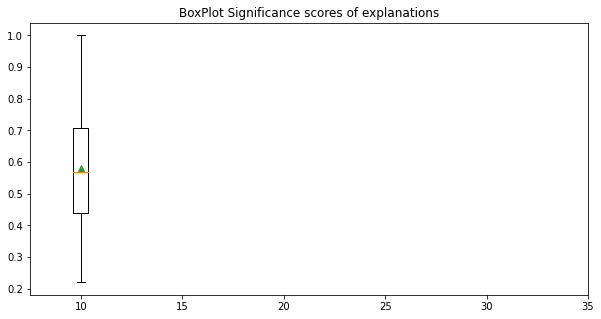

In [ ]:
plt.figure(figsize=(10,5))
plt.title('BoxPlot Significance scores of explanations')
plt.boxplot( df, showmeans=True)
plt.xticks(ticks = [1,2,3,4,5, 6], labels=['10','15','20','25','30','35'])
plt.show()

In [ ]:
with open('../Confronto sLIME/slimeGOW','wb') as f:
  pickle.dump(score_expls[30], f)

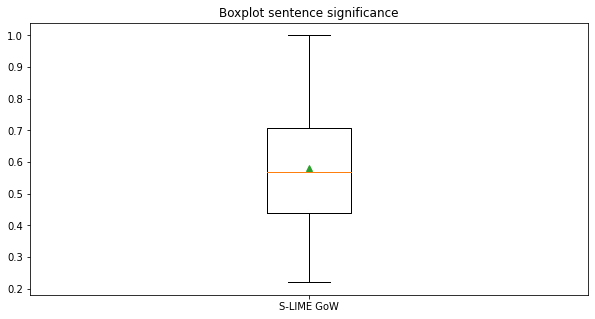

In [ ]:
explanations = df.T[30]

plt.figure(figsize=(10,5))
plt.boxplot( explanations, showfliers=False, showmeans=True )
#plt.ylim((0.0,1.0))
plt.xticks([1],['S-LIME GoW'])
plt.title("Boxplot sentence significance")
plt.show()

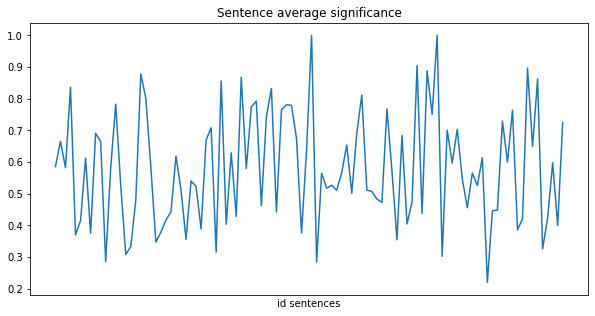

In [ ]:
explanations = df.T[30]

plt.figure(figsize=(10,5))
plt.plot( np.arange(len(explanations)), explanations )
plt.xlabel("id sentences")
plt.title("Sentence average significance")
#plt.ylim((0.0, 1.0))
plt.xticks([])
plt.show()

YELP
===

In [ ]:
tf = SentenceTransformer('stsb-roberta-large')
file_out = open("result_output/output"+data+".txt",'w')
output = []
for i in range(len(slime_res)):
  ph = sents[i][:-1]
  ph = lt([ph])[0]

  e1 = tf.encode(ph, convert_to_tensor=True)

  #print(sents[i][:-1],'==>',slime_res[i])
  file_out.write( sents[i][:-1] + ' ==> ' + str(slime_res[i]) + '\n')

  dict_words = {}
  for j in slime_res[i]:
    e2 = tf.encode(j, convert_to_tensor=True)
    dict_words[j] = (final_score(j, ph, e1, e2, classifier_fn), 
                     score_sim_parola(j, e1, e2), 
                     score_parola(j))
  
  #pickle.dump( (ph, dict_words), open('result_'+data+'/output_'+str(i),'wb') )

  #print("\tWORDS ".ljust(40),":\t", "FINAL".ljust(6), '\t', "SIM".ljust(6), '\t', "SCORE".ljust(6) )
  file_out.write("\tWORDS ".ljust(40)+":\t" + " FINAL".ljust(6)+'\t\t' + " SIM".ljust(6)+ '\t\t'+ " SCORE".ljust(6) + '\n')
  dict_words_sort = sorted( dict_words.items(), key=(lambda x: x[1][0]), reverse=True )

  for elem in dict_words_sort:
    #print("\t"+elem[0].ljust(40),":\t", "%.4f" % elem[1][0], ":\t", "%.4f" % elem[1][1], ":\t", "%.4f" % elem[1][2])
    file_out.write( "\t"+elem[0].ljust(40) + ":\t " + str("%.4f" % elem[1][0]) + ":\t " + str("%.4f" % elem[1][1]) + ":\t " + str("%.4f" % elem[1][2]) + '\n')
  
  scores = [v[0] for k,v in dict_words.items() ]
  output.append( scores )
  
  file_out.write('\n\n')
  #print()
file_out.close()

In [ ]:
pickle.dump( output, open('../Confronto sLIME/slimeGOW','wb') )
pickle.dump( output, open('result_output/yelp_res','wb') )

YAHOO
===

In [ ]:
tf = SentenceTransformer('stsb-roberta-large')
file_out = open("result_output/output_"+data+".txt",'w')
output = []
for i in range(len(slime_res)):
  ph = sents[i][:-1]
  ph = lt([ph])[0]

  e1 = tf.encode(ph, convert_to_tensor=True)

  #print(sents[i][:-1],'==>',slime_res[i])
  file_out.write( sents[i][:-1] + ' ==> ' + str(slime_res[i]) + '\n')

  dict_words = {}
  for j in slime_res[i]:
    e2 = tf.encode(j, convert_to_tensor=True)
    dict_words[j] = (final_score(j, ph, e1, e2, classifier_fn), 
                     score_sim_parola(j, e1, e2), 
                     score_parola(j))
  
  #pickle.dump( (ph, dict_words), open('result_yahoo/output_'+str(i),'wb') )

  #print("\tWORDS ".ljust(40),":\t", "FINAL".ljust(6), '\t', "SIM".ljust(6), '\t', "SCORE".ljust(6) )
  file_out.write("\tWORDS ".ljust(40)+":\t" + " FINAL".ljust(6)+'\t\t' + " SIM".ljust(6)+ '\t\t'+ " SCORE".ljust(6) + '\n')
  dict_words_sort = sorted( dict_words.items(), key=(lambda x: x[1][0]), reverse=True )

  for elem in dict_words_sort:
    #print("\t"+elem[0].ljust(40),":\t", "%.4f" % elem[1][0], ":\t", "%.4f" % elem[1][1], ":\t", "%.4f" % elem[1][2])
    file_out.write( "\t"+elem[0].ljust(40) + ":\t " + str("%.4f" % elem[1][0]) + ":\t " + str("%.4f" % elem[1][1]) + ":\t " + str("%.4f" % elem[1][2]) + '\n')
  
  scores = [v[0] for k,v in dict_words.items() ]
  output.append( scores )
  
  file_out.write('\n\n')
  #print()
file_out.close()

In [ ]:
pickle.dump( output, open('result_output/yahoo_res','wb') )

TWITTER
====

Print results
---

In [ ]:
tf = SentenceTransformer('stsb-roberta-large')
file_out = open("result_output/output"+data+".txt",'w')

for i in range(len(slime_res)):
  ph = sents[i][:-1]
  ph = lt([ph])[0]

  e1 = tf.encode(ph, convert_to_tensor=True)

  #print(sents[i][:-1],'==>',slime_res[i])
  file_out.write( sents[i][:-1] + ' ==> ' + str(slime_res[i]) + '\n')

  dict_words = {}
  for j in slime_res[i]:
    e2 = tf.encode(j, convert_to_tensor=True)
    dict_words[j] = (final_score(j, ph, e1, e2, classifier_fn), 
                     score_sim_parola(j, e1, e2), 
                     score_parola(j))
  
  #pickle.dump( (ph, dict_words), open('result_'+data+'/output_'+str(i),'wb') )

  #print("\tWORDS ".ljust(40),":\t", "FINAL".ljust(6), '\t', "SIM".ljust(6), '\t', "SCORE".ljust(6) )
  file_out.write("\tWORDS ".ljust(40)+":\t" + " FINAL".ljust(6)+'\t\t' + " SIM".ljust(6)+ '\t\t'+ " SCORE".ljust(6) + '\n')
  dict_words_sort = sorted( dict_words.items(), key=(lambda x: x[1][0]), reverse=True )
  
  for elem in dict_words_sort:
    #print("\t"+elem[0].ljust(40),":\t", "%.4f" % elem[1][0], ":\t", "%.4f" % elem[1][1], ":\t", "%.4f" % elem[1][2])
    file_out.write( "\t"+elem[0].ljust(40) + ":\t " + str("%.4f" % elem[1][0]) + ":\t " + str("%.4f" % elem[1][1]) + ":\t " + str("%.4f" % elem[1][2]) + '\n')

  scores = [v[0] for k,v in dict_words.items() ]
  output.append( scores )

  file_out.write('\n\n')
  #print()
file_out.close()

In [ ]:
pickle.dump( output, open('result_output/twitter_res','wb') )